In [1]:
import pandas as pd

## Funcion de Desviacion estandar de los retornos de los ultimos 5 dias dadas las velas intradía

In [2]:
# Adjusted
df_adj = pd.read_csv(r"D:\OneDrivePersonal\OneDrive\Maestria\Proyecto Integrador\Acciones_adj\AAPL.csv")
# Raw
dfr = pd.read_csv(r"D:\OneDrivePersonal\OneDrive\Maestria\Proyecto Integrador\Acciones\AAPL.csv")

In [3]:
def compute_std_return_last5d(df):
    """
    Calcula la volatilidad (std) de los retornos diarios de los últimos 5 días
    usando todos los datos intradía (incluye pre y post market).
    
    Input:
        df: DataFrame intradía SOLO de un símbolo, columnas mínimas:
            - symbol
            - timestamp (datetime con tz o string)
            - close (precio ajustado)
    
    Output:
        DataFrame con columnas:
            - symbol
            - date
            - std_return_last5d
    """
    import pandas as pd
    import numpy as np
    from zoneinfo import ZoneInfo

    df = df.copy()

    # --- Convertir timestamp a datetime y aplicar zona horaria NYC ---
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)  # parsea tz-aware
    df['timestamp'] = df['timestamp'].dt.tz_convert('America/New_York')

    # --- Hacer timestamp naive (sin tz), necesario para agrupar fácilmente ---
    df['timestamp'] = df['timestamp'].dt.tz_localize(None)

    # --- Crear columna "date" para agrupación diaria ---
    df['date'] = df['timestamp'].dt.date

    # --- Ordenar por tiempo ---
    df = df.sort_values('timestamp')

    # --- Calcular log-return intradía ---
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))

    # --- Resetear retornos en cambio de día ---
    df.loc[df['date'] != df['date'].shift(1), 'log_ret'] = np.nan

    # --- Agregar retornos intradía a retorno diario ---
    daily = df.groupby('date').agg({
        'symbol': 'first',
        'log_ret': 'sum'
    }).reset_index()

    daily.rename(columns={'log_ret': 'daily_log_return'}, inplace=True)

    # --- Rolling std 5d ---
    daily['std_return_last5d'] = daily['daily_log_return'].rolling(window=5).std()

    # --- Output final ---
    output = daily[['symbol', 'date', 'std_return_last5d']]
    output['timestamp'] = pd.to_datetime(output['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    output = output.drop(columns=['date'])
    output.insert(1, 'timestamp', output.pop('timestamp'))
    
    return output

In [4]:
df_std_return_last5d = compute_std_return_last5d(df_adj)
df_std_return_last5d.head()

,symbol,timestamp,std_return_last5d
0,AAPL,2015-12-31 04:00:00-05:00,NaN
1,AAPL,2016-01-04 04:00:00-05:00,NaN
2,AAPL,2016-01-05 04:00:00-05:00,NaN
3,AAPL,2016-01-06 04:00:00-05:00,NaN
4,AAPL,2016-01-07 04:00:00-05:00,0.017831


<Axes: xlabel='timestamp'>

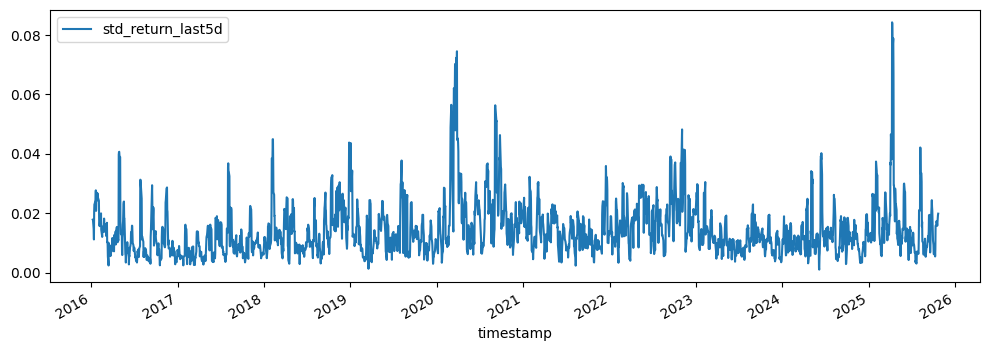

In [5]:
df_std_return_last5d.plot(x='timestamp', y='std_return_last5d', figsize=(12,4))

## Calculo de range_rel 

range_rel = (high_n-1 - low_n-1) / close_n-1

In [6]:
def compute_range_rel_last1d(df):
    """
    Calcula range_rel_last1d = (high_low / close) del día n-1,
    usando datos intradía (30 min).

    Salida:
      - symbol
      - date (día n)
      - range_rel_last1d
    """
    import pandas as pd
    from zoneinfo import ZoneInfo

    df = df.copy()

    # --- Asegurar timestamp con tz New York ---
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["timestamp"] = df["timestamp"].dt.tz_convert("America/New_York")

    # Fecha diaria
    df["date"] = df["timestamp"].dt.date

    # --- Agregación intradía por día ---
    daily = df.groupby("date").agg(
        day_high=("high", "max"),
        day_low=("low", "min"),
        day_close=("close", "last"),
        symbol=("symbol", "first")
    ).reset_index()

    # Range relativo
    daily["range_rel"] = (daily["day_high"] - daily["day_low"]) / daily["day_close"]

    # Shift para usar el valor del día n-1
    daily["range_rel_last1d"] = daily["range_rel"].shift(1)

    # Eliminar el primer día (NaN)
    #daily = daily.dropna(subset=["range_rel_last1d"])

    # --- Seleccionar columnas finales ---
    output = daily[["symbol", "date", "range_rel_last1d"]].copy()
    output['timestamp'] = pd.to_datetime(output['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    output = output.drop(columns=['date'])
    output.insert(1, 'timestamp', output.pop('timestamp'))

    return output

In [7]:
df_range = compute_range_rel_last1d(dfr)
df_range.head()


,symbol,timestamp,range_rel_last1d
0,AAPL,2015-12-31 04:00:00-05:00,NaN
1,AAPL,2016-01-04 04:00:00-05:00,0.001422
2,AAPL,2016-01-05 04:00:00-05:00,0.035937
3,AAPL,2016-01-06 04:00:00-05:00,0.036577
4,AAPL,2016-01-07 04:00:00-05:00,0.026842


<Axes: xlabel='timestamp'>

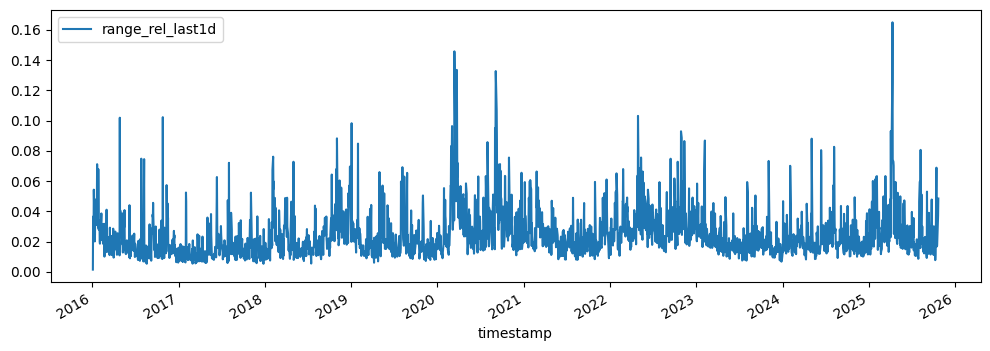

In [8]:
df_range.plot(x='timestamp', y='range_rel_last1d', figsize=(12,4))

## Variable de volumen relativo con los ultimos 20 dias

In [9]:
def compute_rvol_20d(df):
    """
    Calcula rvol_20d usando VOLUMEN EN DÓLARES
    (volume * vwap), para ser inmune a splits.

    Salida:
      - symbol
      - date
      - rvol_20d
    """
    import pandas as pd
    from zoneinfo import ZoneInfo

    df = df.copy()

    # --- Asegurar timestamp NY ---
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["timestamp"] = df["timestamp"].dt.tz_convert("America/New_York")

    # Fecha diaria
    df["date"] = df["timestamp"].dt.date

    # --- Crear volumen en dólares por vela ---
    df["dollar_volume"] = df["volume"] * df["vwap"]

    # --- Sumar por día ---
    daily = df.groupby("date").agg(
        day_dollar_volume=("dollar_volume", "sum"),
        symbol=("symbol", "first")
    ).reset_index()

    # --- Rolling 20 días (sin incluir día actual) ---
    daily["dvol_ma20"] = daily["day_dollar_volume"].rolling(20).mean().shift(1)

    # --- Relative Dollar Volume ---
    daily["rvol_20d"] = daily["day_dollar_volume"] / daily["dvol_ma20"]

    # Remover días sin suficiente historial
    #daily = daily.dropna(subset=["rvol_20d"])

    daily['timestamp'] = pd.to_datetime(daily['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    daily = daily.drop(columns=['date'])
    daily.insert(1, 'timestamp', daily.pop('timestamp'))

    # Salida final
    return daily[["symbol", "timestamp", "rvol_20d"]]

In [10]:
df_rvol = compute_rvol_20d(dfr)
df_rvol.head(30)

,symbol,timestamp,rvol_20d
0,AAPL,2015-12-31 04:00:00-05:00,NaN
1,AAPL,2016-01-04 04:00:00-05:00,NaN
2,AAPL,2016-01-05 04:00:00-05:00,NaN
3,AAPL,2016-01-06 04:00:00-05:00,NaN
4,AAPL,2016-01-07 04:00:00-05:00,NaN
5,AAPL,2016-01-08 04:00:00-05:00,NaN
6,AAPL,2016-01-11 04:00:00-05:00,NaN
7,AAPL,2016-01-12 04:00:00-05:00,NaN
8,AAPL,2016-01-13 04:00:00-05:00,NaN
9,AAPL,2016-01-14 04:00:00-05:00,NaN


<Axes: xlabel='timestamp'>

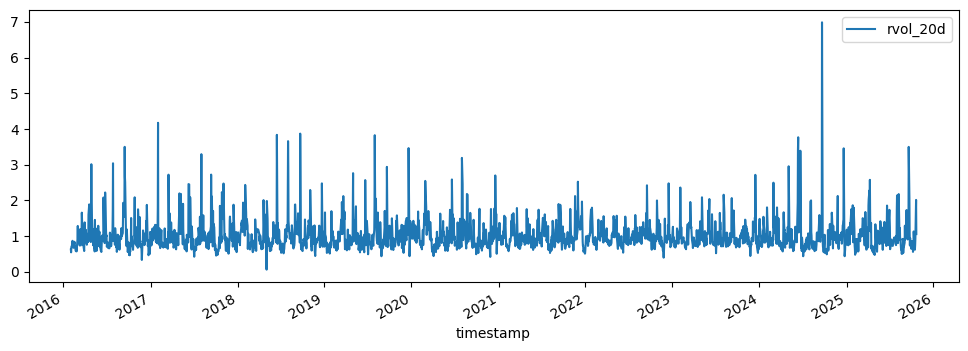

In [11]:
df_rvol.plot(x='timestamp', y='rvol_20d', figsize=(12,4))

## Gap

In [12]:
def compute_gap_pct(df):
    """
    Calcula el overnight/gap basado EXCLUSIVAMENTE en el primer open del premarket.

    Reglas:
      - open_current = primera vela del día con timestamp < 09:30 (NY)
      - si NO existe premarket → open_current = 0
      - close_prev = último close del día anterior
      - si open_current = 0 → gap_pct = 0

    Salida:
      - symbol
      - date
      - gap_pct
    """
    import pandas as pd
    import datetime
    from zoneinfo import ZoneInfo

    df = df.copy()

    # --- Asegurar timezone NY ---
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["timestamp"] = df["timestamp"].dt.tz_convert("America/New_York")
    df["date"] = df["timestamp"].dt.date
    df["time"] = df["timestamp"].dt.time

    # Hora límite para premarket
    REGULAR_OPEN = datetime.time(9, 30)

    # --- Obtener todos los días únicos con su símbolo ---
    all_days = (
        df.groupby("date")
        .agg(symbol=("symbol", "first"))
        .reset_index()
    )

    # --- Para cada día: primera vela del premarket ---
    premarket = (
        df[df["time"] < REGULAR_OPEN]
        .groupby("date")
        .agg(pre_open=("open", "first"))
        .reset_index()
    )

    # Merge y rellenar con 0 si no hay premarket
    daily = all_days.merge(premarket, on="date", how="left")
    daily["pre_open"] = daily["pre_open"].fillna(0)

    # --- Obtener último close de cada día ---
    last_close = (
        df.groupby("date")
        .agg(last_close=("close", "last"))
        .reset_index()
    )

    daily = daily.merge(last_close, on="date", how="left")

    # --- prev_close = último close del día ANTERIOR ---
    daily["prev_close"] = daily["last_close"].shift(1)

    # --- Calcular gap_pct ---
    # Primero inicializar en 0
    daily["gap_pct"] = 0.0

    # Calcular solo donde tenemos prev_close válido Y pre_open != 0
    mask = (daily["prev_close"].notna()) & (daily["pre_open"] != 0)
    daily.loc[mask, "gap_pct"] = (
        (daily.loc[mask, "pre_open"] - daily.loc[mask, "prev_close"]) 
        / daily.loc[mask, "prev_close"]
    )


    daily['timestamp'] = pd.to_datetime(daily['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    daily = daily.drop(columns=['date'])
    daily.insert(1, 'timestamp', daily.pop('timestamp'))

    # Retornar solo las columnas necesarias
    return daily[["symbol", "timestamp", "gap_pct"]].copy()

In [13]:
df_gap = compute_gap_pct(df_adj)
df_gap.head()

,symbol,timestamp,gap_pct
0,AAPL,2015-12-31 04:00:00-05:00,0.000000
1,AAPL,2016-01-04 04:00:00-05:00,0.000000
2,AAPL,2016-01-05 04:00:00-05:00,-0.002515
3,AAPL,2016-01-06 04:00:00-05:00,-0.000433
4,AAPL,2016-01-07 04:00:00-05:00,-0.049166


<Axes: xlabel='timestamp'>

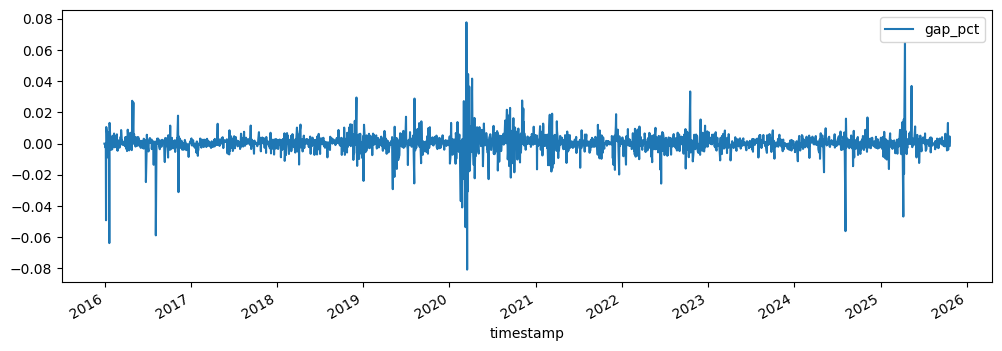

In [14]:
df_gap.plot(x='timestamp', y='gap_pct', figsize=(12,4))

## Variable de Distancia al maximo de 20 dias

In [15]:
def compute_dist_max_20d(df):
    """
    Calcula la distancia al máximo de los últimos 20 días usando solo datos hasta n-1.

    dist_max_20d(n) = (close_{n-1} - max(close_{n-20:n-1})) / max(close_{n-20:n-1})

    Output:
      - symbol
      - date (día n)
      - dist_max_20d
    """
    import pandas as pd
    from zoneinfo import ZoneInfo

    df = df.copy()

    # --- Asegurar timestamp NY ---
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["timestamp"] = df["timestamp"].dt.tz_convert("America/New_York")

    # Fecha diaria
    df["date"] = df["timestamp"].dt.date

    # --- Crear OHLC diario ---
    daily = df.groupby("date").agg(
        close_daily=("close", "last"),
        symbol=("symbol", "first")
    ).reset_index()

    # --- max_20d usando SOLO datos anteriores ---
    daily["max_20d_prev"] = daily["close_daily"].shift(1).rolling(20).max()

    # --- dist_max_20d ---
    daily["dist_max_20d"] = (
        (daily["close_daily"].shift(1) - daily["max_20d_prev"]) / daily["max_20d_prev"]
    )

    # Remover las primeras 21 filas que no tienen info previa
    #daily = daily.dropna(subset=["dist_max_20d"])

    daily['timestamp'] = pd.to_datetime(daily['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    daily = daily.drop(columns=['date'])
    daily.insert(1, 'timestamp', daily.pop('timestamp'))

    return daily[["symbol", "timestamp", "dist_max_20d"]]


In [16]:
df_dmax20 = compute_dist_max_20d(df_adj)
df_dmax20.head(30)

,symbol,timestamp,dist_max_20d
0,AAPL,2015-12-31 04:00:00-05:00,NaN
1,AAPL,2016-01-04 04:00:00-05:00,NaN
2,AAPL,2016-01-05 04:00:00-05:00,NaN
3,AAPL,2016-01-06 04:00:00-05:00,NaN
4,AAPL,2016-01-07 04:00:00-05:00,NaN
5,AAPL,2016-01-08 04:00:00-05:00,NaN
6,AAPL,2016-01-11 04:00:00-05:00,NaN
7,AAPL,2016-01-12 04:00:00-05:00,NaN
8,AAPL,2016-01-13 04:00:00-05:00,NaN
9,AAPL,2016-01-14 04:00:00-05:00,NaN


<Axes: xlabel='timestamp'>

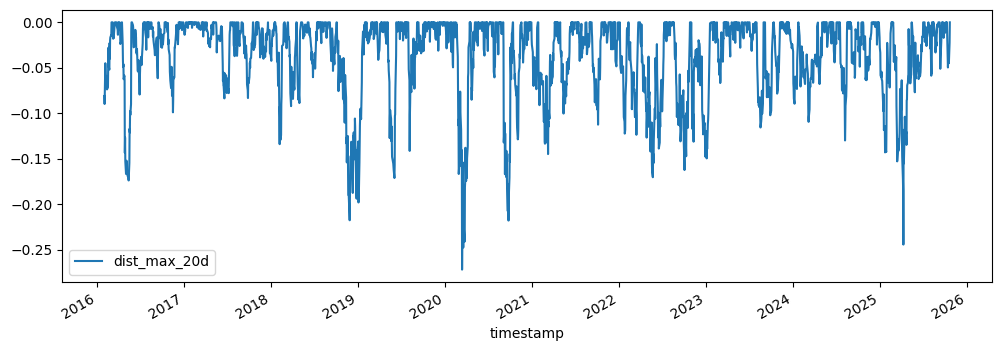

In [17]:
df_dmax20.plot(x='timestamp', y='dist_max_20d', figsize=(12,4))

### Distancia maxima 20 dias Normalizada

<Axes: xlabel='timestamp'>

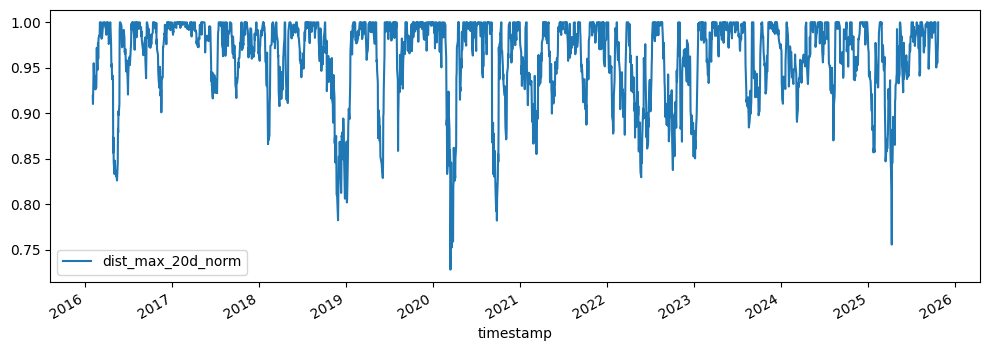

In [18]:
def compute_dist_max_20d_norm(df):
    """
    Distancia normalizada al máximo de los últimos 20 días usando solo datos hasta n-1.
    Output:
      - symbol
      - date
      - dist_max_20d_norm (0-1, 1 = cierre toca máximo reciente)
    """
    import pandas as pd
    from zoneinfo import ZoneInfo

    df = df.copy()

    # Timestamp a NY
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["timestamp"] = df["timestamp"].dt.tz_convert("America/New_York")

    # Fecha diaria
    df["date"] = df["timestamp"].dt.date

    # OHLC diario
    daily = df.groupby("date").agg(
        close_daily=("close", "last"),
        symbol=("symbol", "first")
    ).reset_index()

    # Max de 20 días previos
    daily["max_20d_prev"] = daily["close_daily"].shift(1).rolling(20).max()

    # Distancia normalizada
    daily["dist_max_20d_norm"] = daily["close_daily"].shift(1) / daily["max_20d_prev"]

    # Eliminar primeros 21 días sin info
    #daily = daily.dropna(subset=["dist_max_20d_norm"])

    daily['timestamp'] = pd.to_datetime(daily['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    daily = daily.drop(columns=['date'])
    daily.insert(1, 'timestamp', daily.pop('timestamp'))

    return daily[["symbol", "timestamp", "dist_max_20d_norm"]]


df_dmax20norm = compute_dist_max_20d_norm(df_adj)
df_dmax20norm.plot(x='timestamp', y='dist_max_20d_norm', figsize=(12,4))

## Upper Wick ratio

In [19]:
def compute_upper_wick_ratio_last1d(df):
    """
    Calcula el upper wick ratio promedio del día n-1.
    
    upper_wick_ratio = (high - max(open, close)) / (high - low)
    
    Salida:
      - symbol
      - date (día n)
      - upper_wick_ratio_last1d
    """
    import pandas as pd
    import numpy as np
    from zoneinfo import ZoneInfo

    df = df.copy()

    # Timestamp a NY
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["timestamp"] = df["timestamp"].dt.tz_convert("America/New_York")
    
    # Fecha diaria
    df["date"] = df["timestamp"].dt.date

    # --- Calcular upper wick por vela ---
    df["upper_wick"] = df["high"] - df[["open", "close"]].max(axis=1)
    df["candle_range"] = df["high"] - df["low"]

    # Evitar división por 0
    df["upper_wick_ratio"] = np.where(
        df["candle_range"] == 0,
        0,
        df["upper_wick"] / df["candle_range"]
    )

    # --- Promedio diario por día ---
    daily = df.groupby("date").agg(
        upper_wick_ratio_last1d=("upper_wick_ratio", "mean"),
        symbol=("symbol", "first")
    ).reset_index()

    # Shift para asignar al día n (usar valores del día n-1)
    daily["upper_wick_ratio_last1d"] = daily["upper_wick_ratio_last1d"].shift(1)

    # Eliminar primer día (NaN)
    #daily = daily.dropna(subset=["upper_wick_ratio_last1d"])

    daily['timestamp'] = pd.to_datetime(daily['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    daily = daily.drop(columns=['date'])
    daily.insert(1, 'timestamp', daily.pop('timestamp'))

    return daily[["symbol", "timestamp", "upper_wick_ratio_last1d"]]

In [20]:
df_upper = compute_upper_wick_ratio_last1d(dfr)
df_upper.head()

,symbol,timestamp,upper_wick_ratio_last1d
0,AAPL,2015-12-31 04:00:00-05:00,NaN
1,AAPL,2016-01-04 04:00:00-05:00,0.166667
2,AAPL,2016-01-05 04:00:00-05:00,0.218091
3,AAPL,2016-01-06 04:00:00-05:00,0.256765
4,AAPL,2016-01-07 04:00:00-05:00,0.226401


<Axes: xlabel='timestamp'>

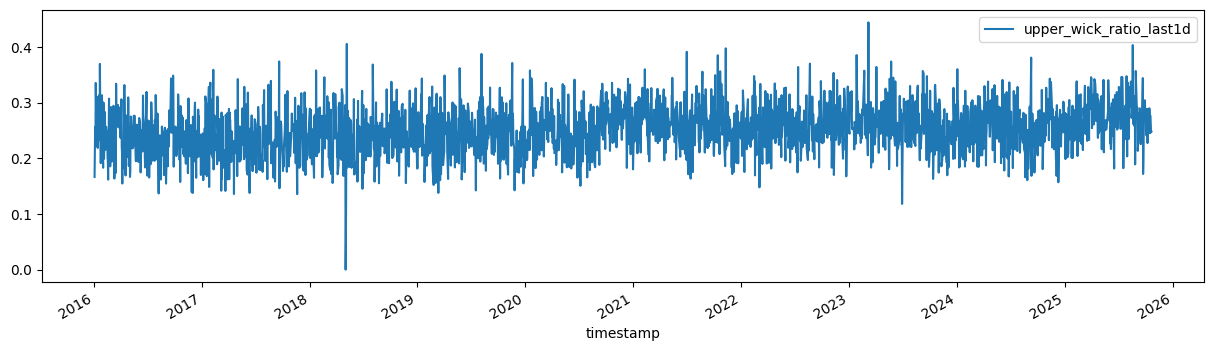

In [21]:
df_upper.plot(x='timestamp', y='upper_wick_ratio_last1d', figsize=(15,4))

## Lower Wick ratio

In [22]:
def compute_lower_wick_ratio_last1d(df):
    """
    Calcula el lower wick ratio promedio del día n-1.
    
    lower_wick_ratio = (min(open, close) - low) / (high - low)
    
    Salida:
      - symbol
      - date (día n)
      - lower_wick_ratio_last1d
    """
    import pandas as pd
    import numpy as np
    from zoneinfo import ZoneInfo

    df = df.copy()

    # Timestamp a NY
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["timestamp"] = df["timestamp"].dt.tz_convert("America/New_York")
    
    # Fecha diaria
    df["date"] = df["timestamp"].dt.date

    # --- Calcular lower wick por vela ---
    df["lower_wick"] = df[["open", "close"]].min(axis=1) - df["low"]
    df["candle_range"] = df["high"] - df["low"]

    # Evitar división por 0
    df["lower_wick_ratio"] = np.where(
        df["candle_range"] == 0,
        0,
        df["lower_wick"] / df["candle_range"]
    )

    # --- Promedio diario por día ---
    daily = df.groupby("date").agg(
        lower_wick_ratio_last1d=("lower_wick_ratio", "mean"),
        symbol=("symbol", "first")
    ).reset_index()

    # Shift para asignar al día n (usar valores del día n-1)
    daily["lower_wick_ratio_last1d"] = daily["lower_wick_ratio_last1d"].shift(1)

    # Eliminar primer día (NaN)
    #daily = daily.dropna(subset=["lower_wick_ratio_last1d"])

    daily['timestamp'] = pd.to_datetime(daily['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    daily = daily.drop(columns=['date'])
    daily.insert(1, 'timestamp', daily.pop('timestamp'))

    return daily[["symbol", "timestamp", "lower_wick_ratio_last1d"]]

In [23]:
df_lower = compute_lower_wick_ratio_last1d(dfr)
df_lower.head()

,symbol,timestamp,lower_wick_ratio_last1d
0,AAPL,2015-12-31 04:00:00-05:00,NaN
1,AAPL,2016-01-04 04:00:00-05:00,0.166667
2,AAPL,2016-01-05 04:00:00-05:00,0.337230
3,AAPL,2016-01-06 04:00:00-05:00,0.261636
4,AAPL,2016-01-07 04:00:00-05:00,0.268395


<Axes: xlabel='timestamp'>

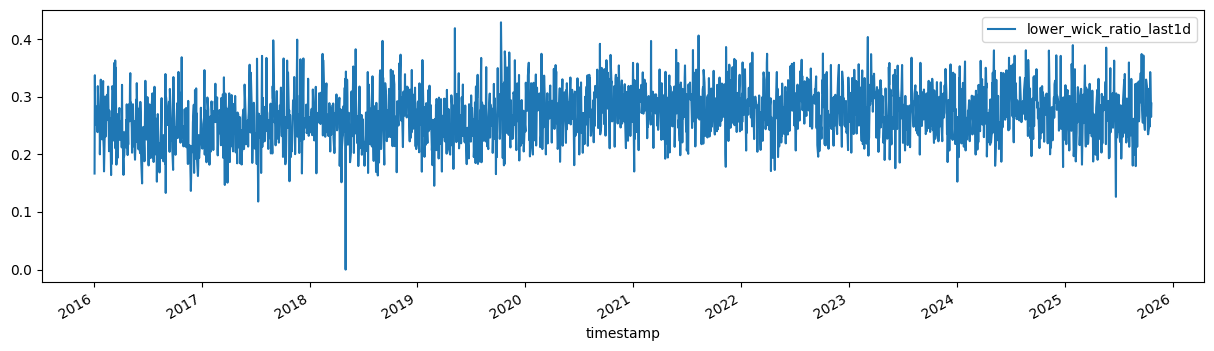

In [24]:
df_lower.plot(x='timestamp', y='lower_wick_ratio_last1d', figsize=(15,4))

## WeekDay (One hot encoding)

In [25]:
def compute_weekday(df):
    """
    Crea columnas one-hot para el día de la semana.
    Salida:
      - symbol
      - date
      - weekday_0 ... weekday_4 (lunes=0,...,viernes=4)
    """
    import pandas as pd
    from zoneinfo import ZoneInfo

    df = df.copy()

    # Asegurarse de tener 'date' tipo datetime.date
    if 'timestamp' in df.columns:
        df["date"] = pd.to_datetime(df["timestamp"], utc=True).dt.tz_convert("America/New_York").dt.date

    # Día de la semana
    df["weekday"] = pd.to_datetime(df["date"]).dt.weekday  # lunes=0, viernes=4

    # One-hot encoding
    df_weekday = pd.get_dummies(df["weekday"], prefix="weekday")

    # Combinar
    output = pd.concat([df[["symbol", "date"]].drop_duplicates().reset_index(drop=True), df_weekday.reset_index(drop=True)], axis=1)

    output['timestamp'] = pd.to_datetime(output['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    output = output.drop(columns=['date'])
    output.insert(1, 'timestamp', output.pop('timestamp'))


    return output


In [26]:
df_wd = compute_weekday(dfr)
df_wd

,symbol,timestamp,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4
0,AAPL,2015-12-31 04:00:00-05:00,False,False,False,True,False
1,AAPL,2016-01-04 04:00:00-05:00,False,False,False,True,False
2,AAPL,2016-01-05 04:00:00-05:00,True,False,False,False,False
3,AAPL,2016-01-06 04:00:00-05:00,True,False,False,False,False
4,AAPL,2016-01-07 04:00:00-05:00,True,False,False,False,False
...,...,...,...,...,...,...,...
76360,NaN,NaT,False,True,False,False,False
76361,NaN,NaT,False,True,False,False,False
76362,NaN,NaT,False,True,False,False,False
76363,NaN,NaT,False,True,False,False,False


## Week day ciclico

In [27]:
def compute_weekday_cyclic(df):
    """
    Convierte el día de la semana en encoding cíclico (seno y coseno).
    
    Input:
      - df: DataFrame con columnas 'timestamp' o 'date' y 'symbol'
    
    Output:
      - DataFrame con columnas:
          symbol, date, weekday_sin, weekday_cos
    """
    import pandas as pd
    import numpy as np
    from zoneinfo import ZoneInfo

    df = df.copy()

    # Asegurarse de tener 'date' como datetime.date
    if 'timestamp' in df.columns:
        df['date'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert("America/New_York").dt.date
    else:
        df['date'] = pd.to_datetime(df['date']).dt.date

    # Día de la semana: lunes=0, martes=1, ..., viernes=4
    df['weekday'] = pd.to_datetime(df['date']).dt.weekday

    # Solo conservar lunes a viernes
    df = df[df['weekday'] < 5]

    # Encoding cíclico
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 5)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 5)

    # Salida final
    output = df[['symbol', 'date', 'weekday_sin', 'weekday_cos']].drop_duplicates().reset_index(drop=True)

    output['timestamp'] = pd.to_datetime(output['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    output = output.drop(columns=['date'])
    output.insert(1, 'timestamp', output.pop('timestamp'))

    return output


In [28]:
df_cyclic = compute_weekday_cyclic(dfr)
df_cyclic.head()

,symbol,timestamp,weekday_sin,weekday_cos
0,AAPL,2015-12-31 04:00:00-05:00,-0.587785,-0.809017
1,AAPL,2016-01-04 04:00:00-05:00,0.000000,1.000000
2,AAPL,2016-01-05 04:00:00-05:00,0.951057,0.309017
3,AAPL,2016-01-06 04:00:00-05:00,0.587785,-0.809017
4,AAPL,2016-01-07 04:00:00-05:00,-0.587785,-0.809017


## Cantodad de dias despues de un festivo

In [29]:
def compute_days_since_holiday_general_c(df):
    """
    Calcula los días transcurridos desde el último festivo del mercado de EE.UU.
    Funciona para cualquier fecha.
    
    Input:
      - df: DataFrame con columna 'date' o 'timestamp' y 'symbol'
    
    Output:
      - symbol, date, days_since_holiday
    """
    import pandas as pd
    import numpy as np
    from pandas.tseries.holiday import USFederalHolidayCalendar
    from zoneinfo import ZoneInfo

    df = df.copy()

    # Asegurarse de tener 'date'
    if 'timestamp' in df.columns:
        df['date'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert("America/New_York").dt.date
    else:
        df['date'] = pd.to_datetime(df['date']).dt.date

    df = df.sort_values('date').drop_duplicates(subset=['date','symbol']).reset_index(drop=True)

    # Generar calendario de festivos US
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['date'].min(), end=df['date'].max()).date

    # Usar searchsorted para eficiencia
    holiday_dates = np.array(holidays)
    days_since_holiday = []
    for d in df['date']:
        idx = np.searchsorted(holiday_dates, d, side='right') - 1
        if idx >= 0:
            delta = (d - holiday_dates[idx]).days
        else:
            delta = np.nan  # No hubo festivo previo
        days_since_holiday.append(delta)

    df['days_since_holiday'] = days_since_holiday


    df['timestamp'] = pd.to_datetime(df['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    df = df.drop(columns=['date'])
    df.insert(1, 'timestamp', df.pop('timestamp'))

    # Salida
    if 'symbol' in df.columns:
        return df[['symbol', 'timestamp', 'days_since_holiday']]
    else:
        return df[['timestamp', 'days_since_holiday']]

df_days_holiday_c = compute_days_since_holiday_general_c(dfr)
df_days_holiday_c

,symbol,timestamp,days_since_holiday
0,AAPL,2015-12-31 04:00:00-05:00,NaN
1,AAPL,2016-01-04 04:00:00-05:00,3.0
2,AAPL,2016-01-05 04:00:00-05:00,4.0
3,AAPL,2016-01-06 04:00:00-05:00,5.0
4,AAPL,2016-01-07 04:00:00-05:00,6.0
...,...,...,...
2461,AAPL,2025-10-15 04:00:00-04:00,2.0
2462,AAPL,2025-10-16 04:00:00-04:00,3.0
2463,AAPL,2025-10-17 04:00:00-04:00,4.0
2464,AAPL,2025-10-20 04:00:00-04:00,7.0


In [30]:
def compute_days_since_holiday_general(df):
    """
    Calcula los días transcurridos desde el último festivo del mercado de EE.UU.
    Funciona para cualquier fecha.
    
    Input:
      - df: DataFrame con columna 'date' o 'timestamp' y 'symbol'
    
    Output:
      - symbol, date, days_since_holiday
    """
    import pandas as pd
    import numpy as np
    from pandas.tseries.holiday import USFederalHolidayCalendar
    from zoneinfo import ZoneInfo

    df = df.copy()

    # Asegurarse de tener 'date'
    if 'timestamp' in df.columns:
        df['date'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert("America/New_York").dt.date
    else:
        df['date'] = pd.to_datetime(df['date']).dt.date

    df = df.sort_values('date').reset_index(drop=True)

    # Generar calendario de festivos US
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['date'].min(), end=df['date'].max()).date

    # Usar searchsorted para eficiencia
    holiday_dates = np.array(holidays)
    days_since_holiday = []
    for d in df['date']:
        idx = np.searchsorted(holiday_dates, d, side='right') - 1
        if idx >= 0:
            delta = (d - holiday_dates[idx]).days
        else:
            delta = np.nan  # No hubo festivo previo
        days_since_holiday.append(delta)

    df['days_since_holiday'] = days_since_holiday


    df['timestamp'] = pd.to_datetime(df['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    df = df.drop(columns=['date'])
    df.insert(1, 'timestamp', df.pop('timestamp'))

    # Salida
    if 'symbol' in df.columns:
        return df[['symbol', 'timestamp', 'days_since_holiday']]
    else:
        return df[['timestamp', 'days_since_holiday']]

df_days_holiday = compute_days_since_holiday_general(dfr)
df_days_holiday

,symbol,timestamp,days_since_holiday
0,AAPL,2015-12-31 04:00:00-05:00,NaN
1,AAPL,2015-12-31 04:00:00-05:00,NaN
2,AAPL,2016-01-04 04:00:00-05:00,3.0
3,AAPL,2016-01-04 04:00:00-05:00,3.0
4,AAPL,2016-01-04 04:00:00-05:00,3.0
...,...,...,...
76360,AAPL,2025-10-21 04:00:00-04:00,8.0
76361,AAPL,2025-10-21 04:00:00-04:00,8.0
76362,AAPL,2025-10-21 04:00:00-04:00,8.0
76363,AAPL,2025-10-21 04:00:00-04:00,8.0


<Axes: xlabel='timestamp'>

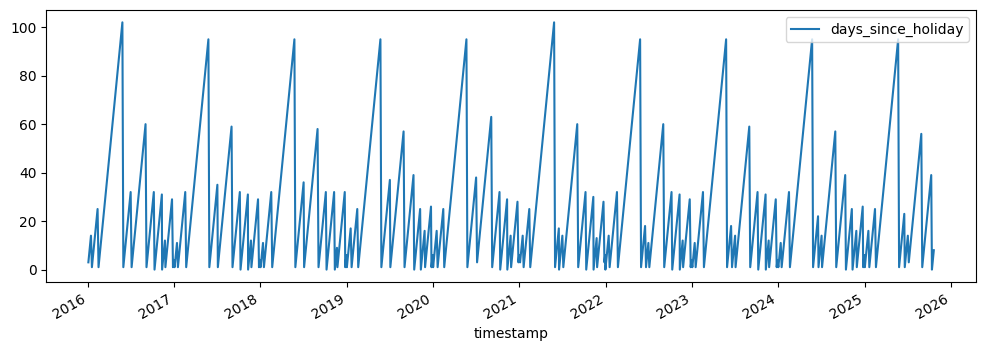

In [31]:
df_days_holiday_c.plot(x='timestamp', y='days_since_holiday', figsize=(12,4))

## Cantidad de dias despues de que el mercado estuvo cerrado distinto de fin de semana

<Axes: xlabel='timestamp'>

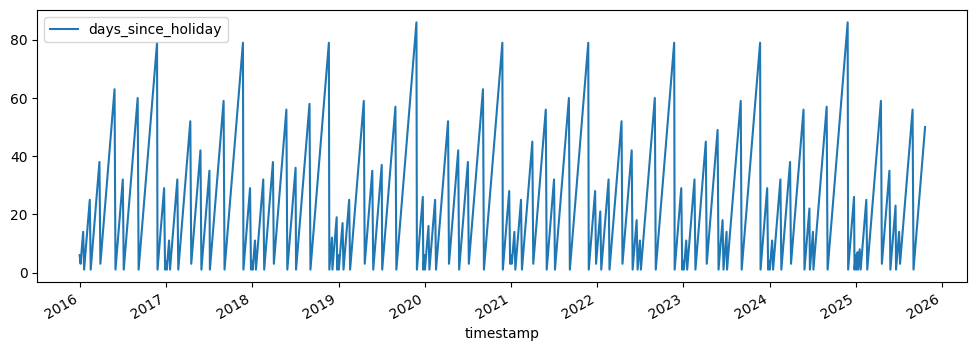

In [32]:
def compute_days_since_market_holiday(df):
    """
    Calcula los días transcurridos desde el último festivo del MERCADO (NYSE).
    Funciona para cualquier fecha.
    
    Input:
      - df: DataFrame con columna 'date' o 'timestamp' y 'symbol'
    
    Output:
      - symbol, date, days_since_holiday
    """
    import pandas as pd
    import numpy as np
    import pandas_market_calendars as mcal
    from zoneinfo import ZoneInfo

    df = df.copy()

    # Asegurarse de tener 'date' como objeto date
    if 'timestamp' in df.columns:
        df['date'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert("America/New_York").dt.date
    else:
        df['date'] = pd.to_datetime(df['date']).dt.date

    df = df.sort_values('date').reset_index(drop=True)

    # Obtener calendario NYSE
    nyse = mcal.get_calendar('NYSE')
    
    # Rango ampliado para asegurar festivos previos
    start = pd.Timestamp(df['date'].min()) - pd.Timedelta(days=730)
    end = pd.Timestamp(df['date'].max())
    
    # Obtener días de trading
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days_set = set(schedule.index.date)
    
    # Calcular festivos: días de lunes a viernes que NO son de trading
    all_business_days = pd.date_range(start, end, freq='B')
    market_holidays = [d.date() for d in all_business_days if d.date() not in trading_days_set]
    
    # Usar searchsorted
    holiday_dates = np.array(sorted(market_holidays))
    days_since_holiday = []
    
    for d in df['date']:
        idx = np.searchsorted(holiday_dates, d, side='right') - 1
        if idx >= 0:
            delta = (d - holiday_dates[idx]).days
        else:
            delta = np.nan
        days_since_holiday.append(delta)

    df['days_since_holiday'] = days_since_holiday

    df['timestamp'] = pd.to_datetime(df['date']).dt.tz_localize("America/New_York") + pd.Timedelta(hours=4)
    df = df.drop(columns=['date'])
    df.insert(1, 'timestamp', df.pop('timestamp'))

    # Salida
    if 'symbol' in df.columns:
        return df[['symbol', 'timestamp', 'days_since_holiday']]
    else:
        return df[['timestamp', 'days_since_holiday']]
    
df_days_market_holiday = compute_days_since_market_holiday(dfr)
df_days_market_holiday.plot(x='timestamp', y='days_since_holiday', figsize=(12,4))

In [33]:
df_days_market_holiday.head()

,symbol,timestamp,days_since_holiday
0,AAPL,2015-12-31 04:00:00-05:00,6
1,AAPL,2015-12-31 04:00:00-05:00,6
2,AAPL,2016-01-04 04:00:00-05:00,3
3,AAPL,2016-01-04 04:00:00-05:00,3
4,AAPL,2016-01-04 04:00:00-05:00,3


## Retorno del dia anterior

<Axes: xlabel='timestamp'>

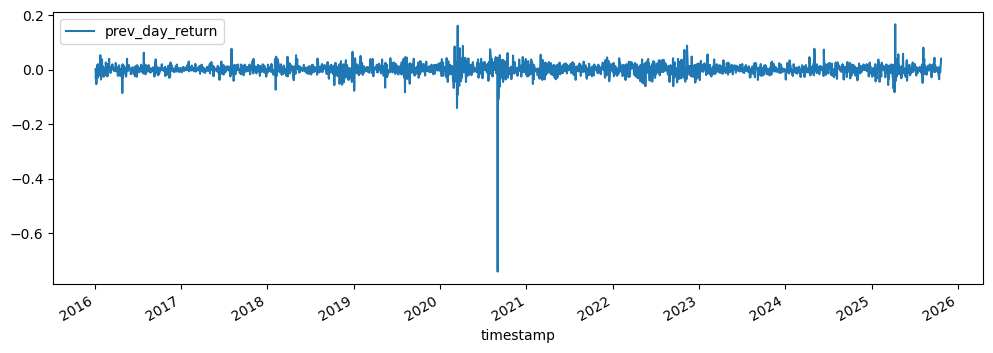

In [34]:
def compute_prev_day_return(df):
    """
    Calcula el retorno del día anterior usando cierres diarios.
    
    Input:
      - df: DataFrame con columnas intradía: timestamp, close, symbol
      - Velas intradía de cualquier frecuencia (30 min, etc.)
    
    Output:
      - DataFrame con columnas: symbol, timestamp, prev_day_return
    """
    import pandas as pd
    from zoneinfo import ZoneInfo

    df = df.copy()

    # Timestamp a datetime y zona NY
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_convert("America/New_York")

    # Crear columna de fecha
    df['date'] = df['timestamp'].dt.date

    # Cierre diario
    daily_close = df.groupby(['symbol', 'date']).agg(
        close_daily=('close', 'last')
    ).reset_index()

    # Retorno del día anterior (shift 1 día)
    daily_close['prev_day_return'] = daily_close.groupby('symbol')['close_daily'].pct_change().shift(1)

    # Eliminar NaN inicial
    #daily_close = daily_close.dropna(subset=['prev_day_return'])

    daily_close['timestamp'] = pd.to_datetime(daily_close['date']).dt.tz_localize(ZoneInfo("America/New_York")) + pd.Timedelta(hours=4)
    daily_close = daily_close.drop(columns=['date'])
    daily_close.insert(1, 'timestamp', daily_close.pop('timestamp'))


    return daily_close[['symbol', 'timestamp', 'prev_day_return']]
df_prev_return = compute_prev_day_return(dfr)
df_prev_return.head()
df_prev_return.plot(x='timestamp', y='prev_day_return', figsize=(12,4))

## Índice de Herfindahl-Hirschman (HHI)

Valores típicos:

- HHI≈0.1–0.2 → volumen distribuido
- HHI≈0.3–0.5 → volumen moderadamente concentrado
- HHI>0.5 → volumen muy concentrado

In [35]:
def compute_hhi_premarket_volume(df):
    """
    Calcula el índice de Herfindahl-Hirschman (HHI) del volumen
    durante el pre-market (04:00–09:30 NY time) para cada día.

    Input:
      df con columnas:
        - timestamp
        - volume
        - symbol

    Output:
      DataFrame con:
        - symbol
        - date
        - hhi_premarket_volume
    """
    import pandas as pd
    import numpy as np

    df = df.copy()

    # Convertir timestamp a NY
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_convert("America/New_York")

    # Extraer fecha y hora local
    df['date'] = df['timestamp'].dt.date
    df['time'] = df['timestamp'].dt.time

    # Definir rango pre-market
    pre_start = pd.to_datetime("04:00:00").time()
    pre_end   = pd.to_datetime("09:30:00").time()

    # Filtrar velas en horario pre-market
    pre = df[(df['time'] >= pre_start) & (df['time'] < pre_end)].copy()

    # HHI por día
    def hhi(vols):
        total = vols.sum()
        if total == 0:
            return np.nan
        p = vols / total
        return (p ** 2).sum()

    hhi_daily = pre.groupby(['symbol', 'date'])['volume'].apply(hhi).reset_index()
    hhi_daily = hhi_daily.rename(columns={'volume': 'hhi_premarket_volume'})

    hhi_daily['timestamp'] = pd.to_datetime(hhi_daily['date']).dt.tz_localize("America/New_York") + pd.Timedelta(hours=4)
    hhi_daily = hhi_daily.drop(columns=['date'])
    hhi_daily.insert(1, 'timestamp', hhi_daily.pop('timestamp'))

    return hhi_daily


In [36]:
df_hhi = compute_hhi_premarket_volume(dfr)
df_hhi.head()

,symbol,timestamp,hhi_premarket_volume
0,AAPL,2016-01-04 04:00:00-05:00,0.210668
1,AAPL,2016-01-05 04:00:00-05:00,0.251238
2,AAPL,2016-01-06 04:00:00-05:00,0.195007
3,AAPL,2016-01-07 04:00:00-05:00,0.165361
4,AAPL,2016-01-08 04:00:00-05:00,0.257622


<Axes: xlabel='timestamp'>

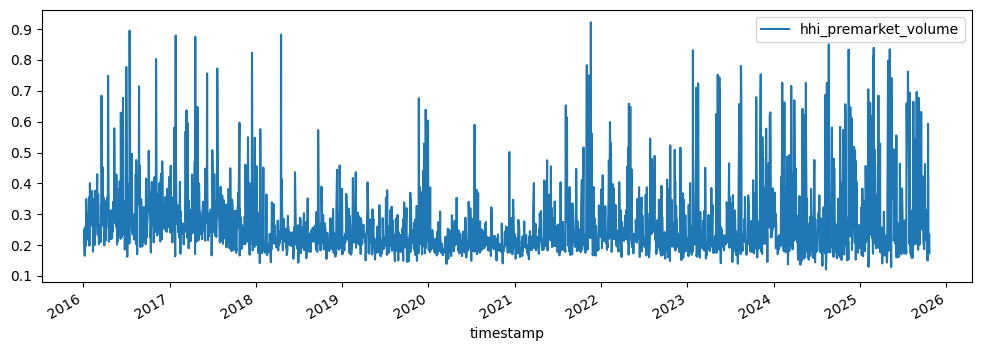

In [37]:
df_hhi.plot(x='timestamp', y='hhi_premarket_volume', figsize=(12,4))

## Premarket Z-score

In [38]:
def compute_premarket_zscore(df, lookback=20):
    """
    Calcula:
      - R_pm : retorno del premarket
      - mu_m : media de daily returns últimos N días
      - sigma_m : std de daily returns últimos N días
      - z_pm : (R_pm - mu_m) / sigma_m

    Input:
      df: dataframe intradía de una sola acción

    Output:
      dataframe con:
        symbol, date, premarket_return, mu_m, sigma_m, z_pm
    """
    import pandas as pd
    import numpy as np

    df = df.copy()

    # Convert timestamp to NY
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_convert("America/New_York")

    df['date'] = df['timestamp'].dt.date
    df['time'] = df['timestamp'].dt.time

    symbol = df['symbol'].iloc[0]

    # --- 1. PREMARKET RETURN ---
    pre_start = pd.to_datetime("04:00:00").time()
    pre_end   = pd.to_datetime("09:30:00").time()

    pre = df[(df['time'] >= pre_start) & (df['time'] < pre_end)]

    pm_daily = pre.groupby('date').agg(
        pm_open=('open', 'first'),
        pm_last=('close', 'last')
    ).reset_index()

    pm_daily['premarket_return'] = (
        (pm_daily['pm_last'] - pm_daily['pm_open']) / pm_daily['pm_open']
    )

    # --- 2. DAILY RETURNS (CLOSE-TO-CLOSE) ---
    daily = df.groupby('date')['close'].last().reset_index()
    daily['daily_return'] = daily['close'].pct_change()

    # --- 3. ROLLING MEAN AND STD ---
    daily['mu_m'] = daily['daily_return'].rolling(lookback).mean()
    daily['sigma_m'] = daily['daily_return'].rolling(lookback).std()

    # Alineamos con pm_daily (que es por día)
    merged = pm_daily.merge(daily, on='date', how='left')

    # --- 4. Z-SCORE ---
    merged['z_pm'] = (
        (merged['premarket_return'] - merged['mu_m']) / merged['sigma_m']
    )

    # limpiar output
    output = merged[['date', 'premarket_return', 'mu_m', 'sigma_m', 'z_pm']].copy()
    output['symbol'] = symbol

    output['timestamp'] = pd.to_datetime(output['date']).dt.tz_localize("America/New_York") + pd.Timedelta(hours=4)
    output = output.drop(columns=['date'])
    output.insert(1, 'timestamp', output.pop('timestamp'))

    return output[['symbol', 'timestamp', 'z_pm']] #output[['symbol', 'timestamp', 'premarket_return', 'mu_m', 'sigma_m', 'z_pm']]

In [39]:
df_zscore = compute_premarket_zscore(dfr[dfr['symbol']=='AAPL'], lookback=20)
df_zscore

,symbol,timestamp,z_pm
0,AAPL,2016-01-04 04:00:00-05:00,NaN
1,AAPL,2016-01-05 04:00:00-05:00,NaN
2,AAPL,2016-01-06 04:00:00-05:00,NaN
3,AAPL,2016-01-07 04:00:00-05:00,NaN
4,AAPL,2016-01-08 04:00:00-05:00,NaN
...,...,...,...
2458,AAPL,2025-10-15 04:00:00-04:00,0.176511
2459,AAPL,2025-10-16 04:00:00-04:00,-0.492272
2460,AAPL,2025-10-17 04:00:00-04:00,0.388257
2461,AAPL,2025-10-20 04:00:00-04:00,0.491091


<Axes: >

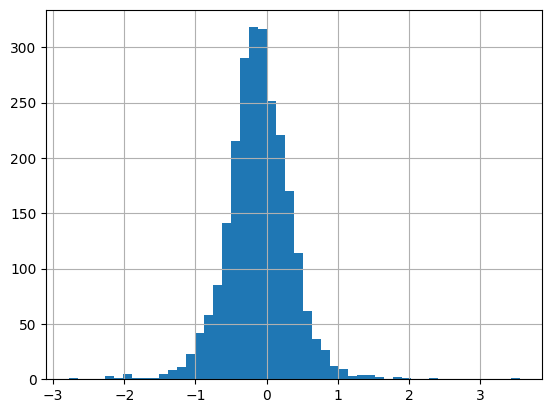

In [40]:
df_zscore['z_pm'].hist(bins=50) # Deberia estar centrado en cero

## Relative premarket average size

In [41]:
def compute_premarket_avg_trade_size_ratio(df, lookback=20, eps=1):
    """
    Calcula R_PM_hist:
      log( (avg_trade_size_today + eps) / (median_historical_avg_trade_size + eps) )
    
    Input:
      df  -> dataframe intradía de una sola acción
    Output:
      dataframe con columnas:
        symbol, date, R_PM_hist
    """
    import pandas as pd
    import numpy as np

    df = df.copy()

    # Convertir timestamp a NY
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_convert("America/New_York")

    df['date'] = df['timestamp'].dt.date
    df['time'] = df['timestamp'].dt.time

    symbol = df['symbol'].iloc[0]

    # --- Filtrar premarket ---
    pre_start = pd.to_datetime("04:00:00").time()
    pre_end   = pd.to_datetime("09:30:00").time()

    pre = df[(df['time'] >= pre_start) & (df['time'] < pre_end)]

    # If no premarket, return empty DF
    if pre.empty:
        return pd.DataFrame(columns=['symbol', 'date', 'R_PM_hist'])

    # --- 1. avg trade size por día ---
    pm_daily = pre.groupby('date').agg(
        total_volume=('volume', 'sum'),
        total_trades=('trade_count', 'sum')
    ).reset_index()

    pm_daily['avg_trade_size'] = pm_daily['total_volume'] / pm_daily['total_trades']

    # --- 2. baseline histórico (rolling median) ---
    pm_daily['median_hist'] = (
        pm_daily['avg_trade_size']
        .rolling(lookback)
        .median()
    )

    # --- 3. log ratio ---
    pm_daily['R_PM_hist'] = np.log(
        (pm_daily['avg_trade_size'] + eps) /
        (pm_daily['median_hist'] + eps)
    )

    # Output final
    out = pm_daily[['date', 'R_PM_hist']].copy()
    out['symbol'] = symbol
    out['timestamp'] = pd.to_datetime(out['date']).dt.tz_localize("America/New_York") + pd.Timedelta(hours=4)
    out = out.drop(columns=['date'])
    out.insert(1, 'timestamp', out.pop('timestamp'))

    return out[['symbol', 'timestamp', 'R_PM_hist']]

In [42]:
df_relative_avg_trade_size = compute_premarket_avg_trade_size_ratio(dfr[dfr['symbol']=='AAPL'], lookback=20, eps=0.01)
df_relative_avg_trade_size.head()

,symbol,timestamp,R_PM_hist
0,AAPL,2016-01-04 04:00:00-05:00,NaN
1,AAPL,2016-01-05 04:00:00-05:00,NaN
2,AAPL,2016-01-06 04:00:00-05:00,NaN
3,AAPL,2016-01-07 04:00:00-05:00,NaN
4,AAPL,2016-01-08 04:00:00-05:00,NaN


<Axes: xlabel='timestamp'>

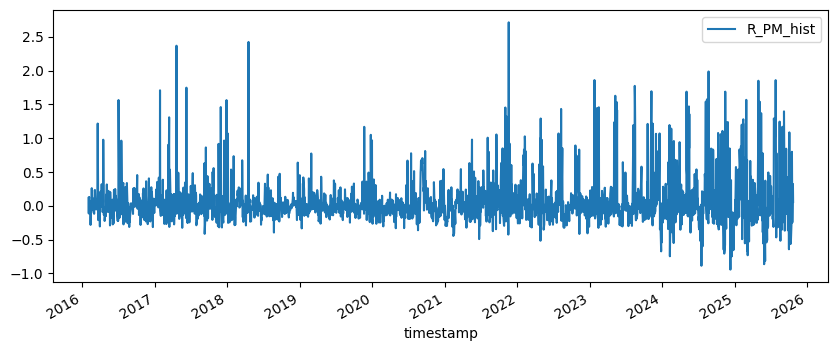

In [43]:
df_relative_avg_trade_size.plot(x='timestamp', y='R_PM_hist', figsize=(10,4))


<Axes: >

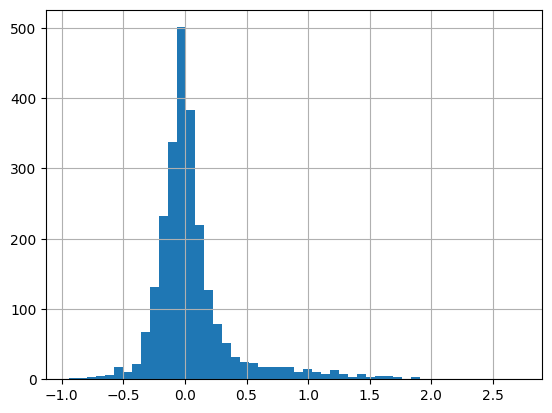

In [44]:
df_relative_avg_trade_size['R_PM_hist'].hist(bins=50)


## Premarket vwap return

In [45]:
def compute_premarket_vwap_return(df):
    """
    Calcula:
        - VWAP_pm: VWAP ponderado del premarket
        - PM_VWAP_Return = VWAP_pm / close_prev - 1

    Input:
        df: dataframe intradia de una sola acción con columnas:
            timestamp, open, high, low, close, vwap, volume, trade_count, symbol

    Output:
        dataframe con columnas:
            symbol, date, PM_VWAP_Return
    """
    import pandas as pd
    import numpy as np

    df = df.copy()

    # Convertir timestamp a NY
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_convert("America/New_York")

    df['date'] = df['timestamp'].dt.date
    df['time'] = df['timestamp'].dt.time

    symbol = df['symbol'].iloc[0]

    # --- 1. Filtrar premarket 04:00 - 09:30 ---
    pre_start = pd.to_datetime("04:00:00").time()
    pre_end   = pd.to_datetime("09:30:00").time()

    pre = df[(df['time'] >= pre_start) & (df['time'] < pre_end)]

    # VWAP pm: Σ(VWAP_i * vol_i) / Σ(vol_i)
    pm_daily = pre.groupby('date').apply(
        lambda g: np.sum(g['vwap'] * g['volume']) / np.sum(g['volume'])
        if g['volume'].sum() > 0 else np.nan
    ).reset_index(name='vwap_pm')

    # --- 2. Obtener el close previo (solo regular hours) ---
    reg_start = pd.to_datetime("09:30:00").time()
    reg_end   = pd.to_datetime("16:00:00").time()

    reg = df[(df['time'] >= reg_start) & (df['time'] < reg_end)]

    daily_close = reg.groupby('date')['close'].last().reset_index()
    daily_close['prev_close'] = daily_close['close'].shift(1)

    # Merge vwap_pm con prev_close
    merged = pm_daily.merge(daily_close[['date', 'prev_close']], on='date', how='left')

    # --- 3. PM VWAP Return ---
    merged['PM_VWAP_Return'] = merged['vwap_pm'] / merged['prev_close'] - 1

    # Output final limpio
    out = merged[['date', 'PM_VWAP_Return']].copy()
    out['symbol'] = symbol

    out['timestamp'] = pd.to_datetime(out['date']).dt.tz_localize("America/New_York") + pd.Timedelta(hours=4)
    out = out.drop(columns=['date'])

    return out[['symbol', 'timestamp', 'PM_VWAP_Return']]


In [46]:
df_premarket_vwap_return = compute_premarket_vwap_return(df_adj[df_adj['symbol']=='AAPL']) # Revisar si es con el df_adj o dfr
df_premarket_vwap_return

C:\Users\Usuario\AppData\Local\Temp\ipykernel_26672\3846151385.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pm_daily = pre.groupby('date').apply(


,symbol,timestamp,PM_VWAP_Return
0,AAPL,2016-01-04 04:00:00-05:00,NaN
1,AAPL,2016-01-05 04:00:00-05:00,-0.000787
2,AAPL,2016-01-06 04:00:00-05:00,-0.022820
3,AAPL,2016-01-07 04:00:00-05:00,-0.025614
4,AAPL,2016-01-08 04:00:00-05:00,0.011721
...,...,...,...
2458,AAPL,2025-10-15 04:00:00-04:00,0.007582
2459,AAPL,2025-10-16 04:00:00-04:00,-0.000975
2460,AAPL,2025-10-17 04:00:00-04:00,-0.003278
2461,AAPL,2025-10-20 04:00:00-04:00,0.014120


<Axes: xlabel='timestamp'>

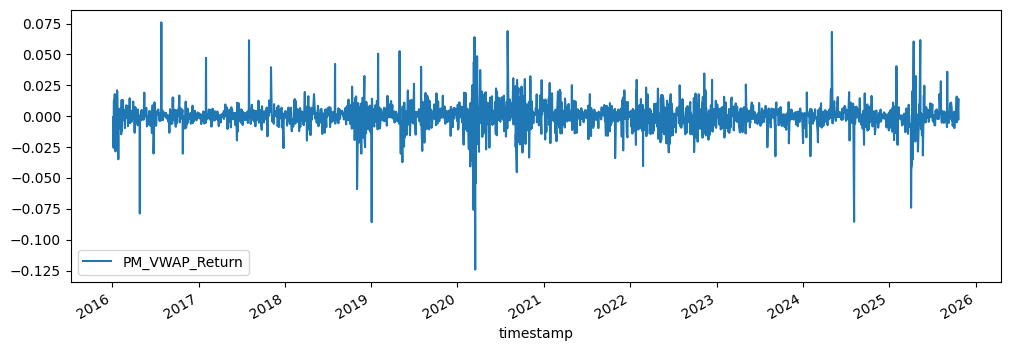

In [47]:
df_premarket_vwap_return.plot(x='timestamp', y='PM_VWAP_Return', figsize=(12,4))

## Struggle

In [ ]:
def compute_va_struggle_premarket(df, eps=1e-4): # !!!! OJO con el epsilon, si es muy pequeño se explota la variable en algunos puntos
    """
    Calcula VA_Struggle para el premarket de cada día.

    Input:
      - df: DataFrame intradía de UNA SOLA acción con columnas mínimas:
            'symbol', 'timestamp', 'close', 'volume'
      - eps: pequeño constante para evitar división por cero (default 1e-8)

    Output:
      - DataFrame con columnas: ['symbol', 'date', 'va_struggle']
        donde 'date' es el día (datetime.date) y va_struggle es el ratio descrito.
    """
    import pandas as pd
    import numpy as np

    df = df.copy()
    # --- timestamp a timezone NY ---
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_convert('America/New_York')
    df = df.sort_values('timestamp')

    # columnas date y time
    df['date'] = df['timestamp'].dt.date
    df['time'] = df['timestamp'].dt.time

    # --- calcular log-returns globales (usando la continuidad temporal) ---
    # esto dará r_i para cada vela respecto a la vela anterior en el timeline
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
    # la primera fila tendrá NaN; está bien (se ignorará si no está en premarket)

    # Filtrar premarket (04:00 - 09:30 NY)
    pm_start = pd.to_datetime("04:00:00").time()
    pm_end   = pd.to_datetime("09:30:00").time()
    df_pm = df[(df['time'] >= pm_start) & (df['time'] < pm_end)].copy()

    # Si no hay premarket, devolver dataframe vacío con columnas esperadas
    if df_pm.empty:
        return pd.DataFrame(columns=['symbol', 'date', 'va_struggle'])

    # robust volume signal u_i = sqrt(volume)
    df_pm['u'] = np.sqrt(df_pm['volume'].fillna(0))

    # para cada día calcular pesos w_i = u_i / sum u_j
    sum_u = df_pm.groupby('date')['u'].transform('sum')
    # evitar división por cero
    df_pm['w'] = np.where(sum_u > 0, df_pm['u'] / sum_u, 0.0)

    # componente numerador: sum w_i * |r_i|
    df_pm['w_abs_r'] = df_pm['w'] * df_pm['log_ret'].abs().fillna(0.0)

    # componente denominador: abs(sum w_i * r_i)
    df_pm['w_r'] = df_pm['w'] * df_pm['log_ret'].fillna(0.0)

    # sumar por día
    grouped = df_pm.groupby('date').agg(
        numerator = ('w_abs_r', 'sum'),
        denom_raw = ('w_r', 'sum'),
        symbol = ('symbol', 'first')
    ).reset_index()

    # denom = |denom_raw| + eps
    grouped['denom'] = grouped['denom_raw'].abs() + eps

    # VA_Struggle
    grouped['va_struggle'] = grouped['numerator'] / grouped['denom']

    # Seleccionar salida
    out = grouped[['symbol', 'date', 'va_struggle']].copy()
    out['timestamp'] = pd.to_datetime(out['date']).dt.tz_localize("America/New_York") + pd.Timedelta(hours=4)
    out = out.drop(columns=['date'])
    out.insert(1, 'timestamp', out.pop('timestamp'))
    return out


In [76]:
df_struggle = compute_va_struggle_premarket(dfr[dfr['symbol']=='AAPL'])
df_struggle

,symbol,timestamp,va_struggle
0,AAPL,2016-01-04 04:00:00-05:00,1.187528
1,AAPL,2016-01-05 04:00:00-05:00,1.242880
2,AAPL,2016-01-06 04:00:00-05:00,6.197255
3,AAPL,2016-01-07 04:00:00-05:00,4.142247
4,AAPL,2016-01-08 04:00:00-05:00,1.142536
...,...,...,...
2458,AAPL,2025-10-15 04:00:00-04:00,7.362054
2459,AAPL,2025-10-16 04:00:00-04:00,1.412173
2460,AAPL,2025-10-17 04:00:00-04:00,2.066665
2461,AAPL,2025-10-20 04:00:00-04:00,2.485613


<Axes: xlabel='timestamp'>

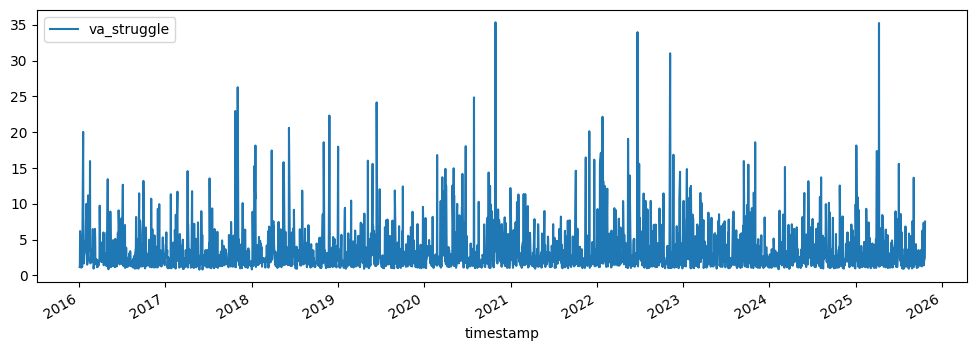

In [77]:
df_struggle.plot(x='timestamp', y='va_struggle', figsize=(12,4))

## Abs Path

In [93]:
def compute_premarket_absolute_path(df, datetime_col='datetime', price_col='close'):
    """
    Calcula el recorrido absoluto del precio en el premarket por día.
    
    Parámetros:
        df : DataFrame con velas intradía (incluye premarket)
        datetime_col : nombre de la columna con timestamp
        price_col : nombre de la columna del precio de cierre
    
    Return:
        DataFrame con columnas:
            - date
            - absolute_path
    """
    
    # --- timestamp a timezone NY ---
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_convert('America/New_York')
    df = df.sort_values('timestamp')


    # Asegurar datetime
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    
    # Crear columna de fecha
    df['date'] = df[datetime_col].dt.date
    
    # Filtrar solo premarket (4:00 a 9:30)
    pm_mask = (
        (df[datetime_col].dt.time >= pd.to_datetime("04:00").time()) &
        (df[datetime_col].dt.time < pd.to_datetime("09:30").time())
    )
    df_pm = df[pm_mask].copy()
    
    # Dentro de cada día, ordenar
    df_pm = df_pm.sort_values([datetime_col])
    
    # Calcular diferencia absoluta del precio
    df_pm['price_diff'] = df_pm.groupby('date')[price_col].diff().abs()
    
    # Sumar por día
    result = df_pm.groupby('date')['price_diff'].sum().reset_index()
    result = result.rename(columns={'price_diff': 'absolute_path'})
    
    result['timestamp'] = pd.to_datetime(result['date']).dt.tz_localize("America/New_York") + pd.Timedelta(hours=4)
    result = result.drop(columns=['date'])
    result.insert(1, 'timestamp', result.pop('timestamp'))

    return result


In [94]:
df_abs_path = compute_premarket_absolute_path(dfr[dfr['symbol']=='AAPL'], datetime_col='timestamp', price_col='close')

<Axes: xlabel='timestamp'>

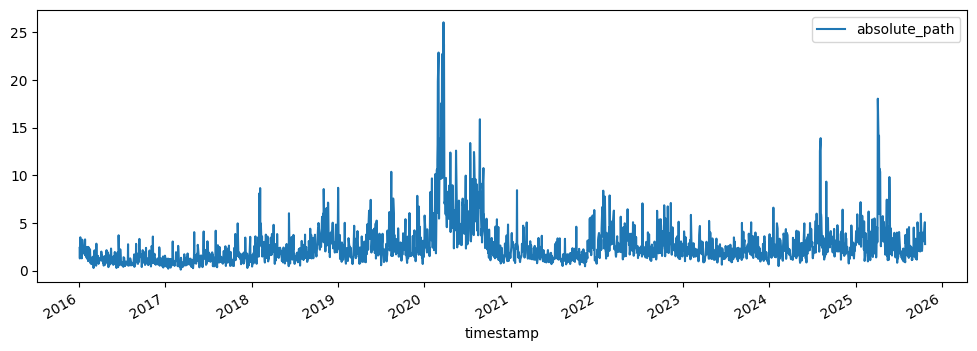

In [95]:
df_abs_path.plot(x='timestamp', y='absolute_path', figsize=(12,4))